In [1]:
import pandas as pd
import sqlalchemy
import math
import os, sys, copy, random, pickle, cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append("../")

%load_ext autoreload
%autoreload 2

from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.Interproc import DBInterface, GuiviewState

from modules.AnalysisHelpers import ( 
         exploreImgs, buildImgComparisonData, subprocEval)

from modules.EvalHelpers import EvalTracker, EvalDataset
from modules.ControlEval import EvalFactory
from modules.DataSchemas import ScoreSchema
from modules.EvalHelpers import OutcomeData, DFHelper

##### Use subprocEval() and let's see the progress bar

In [2]:
# with b_log=True, you get a progress bar + details

tmp_db_path = 'data/misc/books/eval-module-4/evaldb.db'

vid_path = 'data/proc/tmp/dec14/output5.proc1.proc1.avi'

outcome_subproc = subprocEval( f_pathfn = vid_path
                              ,db_pathfn = tmp_db_path 
                             ,b_log = True
                             )


START - running eval module...
[                            ]
-----------------------------
output db: data/misc/books/eval-module-4/evaldb.db
output tbl: outcome_dataframe
total time: 5.217
FINISH - rows: 345 cols: 48 
subproc time: 6.831


In [3]:
# with b_log=False, nothing prints
outcome_subproc = subprocEval( f_pathfn = vid_path
                              ,db_pathfn = tmp_db_path 
                             ,b_log = False
                             )

##### subprocEval returns a pandas df of "outcome_data", we need to calc "eval_data" from this and get that too as a df; use the OutcomeData class

In [9]:
#let's examaine properties of the return object from the subprocEval call
print type(outcome_subproc)
print outcome_subproc.shape
outcome_subproc[:3]

<class 'pandas.core.frame.DataFrame'>
(345, 49)


,index,input_data0_0,input_data0_1,input_data0_2,input_data0_3,input_data1_0,input_data1_1,input_data1_2,input_data1_3,input_data2_0,...,track_data3_2,track_data3_3,track_obj_exists_0,track_obj_exists_1,track_obj_exists_2,track_obj_exists_3,track_obj_type_0,track_obj_type_1,track_obj_type_2,track_obj_type_3
0,0,107.0,111.0,None,None,214.0,218.0,None,None,54.0,...,None,None,True,None,None,None,circle,None,None,None
1,1,NaN,NaN,None,None,NaN,NaN,None,None,NaN,...,None,None,True,None,None,None,circle,None,None,None
2,2,NaN,NaN,None,None,NaN,NaN,None,None,NaN,...,None,None,True,None,None,None,circle,None,None,None


In [13]:
# Now let's get eval data
# note: how we set load=False in the constructor, otherwise it would load
#      the most recent df save to the db in data/usr/ instead of our local
#      notebook obj, <outcome_subproc>

od = OutcomeData(bLoad=False, bEval=False)

assert od.evalData is None

od.loads(outcome_subproc)

od.eval()   # since bEval=False, need to call this manually

assert od.evalData is not None

In [14]:
# so the evalData df has been built
print type(od.evalData)
print od.evalData.shape
od.evalData[:3]

<class 'pandas.core.frame.DataFrame'>
(345, 8)


,checkBaselineInsideTrack,checkBothContainsOther,checkEitherContainsOther,checkTrackInsideBaseline,checkTrackInsideBaselineRect,checkTrackSuccess,compareRadii,distanceFromBaseline
0,True,True,True,True,False,True,6.0,2.236068
1,None,None,None,None,None,None,NaN,NaN
2,None,None,None,None,None,None,NaN,NaN


In [61]:
od.displaySummaryStats()

num frames:                  345
obj enums scored/tracked:    0,1 / 0
num scored frames:           19 | 0,9,78...308,324,340
-------


##### We want to display that info better in notebooks; use DFHelper

In [16]:
evalDf = DFHelper(df=od.evalData.copy(), df_type='eval')

In [18]:
evalDf.setRowsRequested(range_data=range(4))
evalDf.getDatasetDisplay()

,check Both Contains Other,distance From Baseline,check Track Success,check Baseline Inside Track,check Either Contains Other,check Track Inside Baseline,check Track Inside Baseline Rect,compare Radii
0,True,2,True,True,True,True,False,6
1,None,nan,None,None,None,None,None,nan
2,None,nan,None,None,None,None,None,nan
3,None,nan,None,None,None,None,None,nan


In [19]:
evalDf.setRowsRequested(s_cmd='inputframes')
evalDf.getDatasetDisplay()

,check Both Contains Other,distance From Baseline,check Track Success,check Baseline Inside Track,check Either Contains Other,check Track Inside Baseline,check Track Inside Baseline Rect,compare Radii
0,True,2,True,True,True,True,False,6
9,True,7,True,True,True,True,False,7
78,True,1,True,True,True,True,False,-1
116,True,4,True,True,True,True,False,3
136,True,4,True,True,True,True,False,2
176,True,5,True,True,True,True,False,0
187,False,5,True,False,False,False,False,-1
194,False,6,True,False,False,False,False,-2
195,False,4,True,False,False,False,False,-1
201,False,4,True,False,False,False,False,-3


### Let's try aggregating on these tables

In [22]:
print type(evalDf), type(evalDf.df)

<type 'instance'> <class 'pandas.core.frame.DataFrame'>


In [23]:
df = evalDf.df.copy()

In [24]:
df.sum()

checkBaselineInsideTrack          8.000000
checkBothContainsOther            8.000000
checkEitherContainsOther         10.000000
checkTrackInsideBaseline         10.000000
checkTrackInsideBaselineRect      2.000000
checkTrackSuccess                19.000000
compareRadii                      0.000000
distanceFromBaseline            104.332002
dtype: float64

In [25]:
df.min()

checkBaselineInsideTrack        0.0
checkBothContainsOther          0.0
checkEitherContainsOther        0.0
checkTrackInsideBaseline        0.0
checkTrackInsideBaselineRect    0.0
checkTrackSuccess               1.0
compareRadii                   -4.0
distanceFromBaseline            1.0
dtype: float64

In [26]:
df.mean()

checkBaselineInsideTrack        0.421053
checkBothContainsOther          0.421053
checkEitherContainsOther        0.526316
checkTrackInsideBaseline        0.526316
checkTrackInsideBaselineRect    0.105263
checkTrackSuccess               1.000000
compareRadii                    0.000000
distanceFromBaseline            5.491158
dtype: float64

In [28]:
stat_output = df.median()
stat_output

checkBaselineInsideTrack        0.000000
checkBothContainsOther          0.000000
checkEitherContainsOther        1.000000
checkTrackInsideBaseline        1.000000
checkTrackInsideBaselineRect    0.000000
checkTrackSuccess               1.000000
compareRadii                   -1.000000
distanceFromBaseline            5.385165
dtype: float64

In [31]:
print type(stat_output)
print stat_output.shape

<class 'pandas.core.series.Series'>
(8,)


In [40]:
print stat_output[0]
print stat_output[3]

0.0
1.0


In [42]:
print stat_output.checkBaselineInsideTrack
print stat_output['compareRadii']

0.0
-1.0


In [44]:
list(stat_output.index)

['checkBaselineInsideTrack',
 'checkBothContainsOther',
 'checkEitherContainsOther',
 'checkTrackInsideBaseline',
 'checkTrackInsideBaselineRect',
 'checkTrackSuccess',
 'compareRadii',
 'distanceFromBaseline']

In [47]:
list(stat_output.get_values())

[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, -1.0, 5.385164807134504]

In [50]:
evalDf.setRowsRequested(s_cmd='inputframes')
inputframes_rows = evalDf.rows_requested

In [51]:
type(inputframes_rows)

list

### Let's examine how nan's are handled
they are handled well using pandas methods

In [55]:
# note: it's the same for 
print df.mean()
print '--------------------------'
print df[inputframes_rows].mean()

checkBaselineInsideTrack        0.421053
checkBothContainsOther          0.421053
checkEitherContainsOther        0.526316
checkTrackInsideBaseline        0.526316
checkTrackInsideBaselineRect    0.105263
checkTrackSuccess               1.000000
compareRadii                    0.000000
distanceFromBaseline            5.491158
dtype: float64
--------------------------
checkBaselineInsideTrack        0.421053
checkBothContainsOther          0.421053
checkEitherContainsOther        0.526316
checkTrackInsideBaseline        0.526316
checkTrackInsideBaselineRect    0.105263
checkTrackSuccess               1.000000
compareRadii                    0.000000
distanceFromBaseline            5.491158
dtype: float64


In [60]:
# notice how pandas methods works with nan's, but built-in sum doesn't
print sum(df['compareRadii'])
print '-----'
print df['compareRadii'].sum()

nan
-----
0.0


### Build the methods for the new class

In [82]:
def agg_compareRadii(series_data):
    abs_data = series_data.apply(np.abs)
    return abs_data.sum()  # note: use pd's method

agg_compareRadii(df['compareRadii'])

44.0

In [85]:
meth_names = ['sum', 'min', 'mean']
this_series = cr
meth_vals = []

for meth_name in meth_names:

    _aggMeth = getattr(this_series, meth_name)
    
    _val = _aggMeth()
    
    meth_vals.append(_val)
    
print meth_vals

[0.0, -4.0, 0.0]


In [91]:
def inferFieldType(s_field_name):
    if 'check' in s_field_name:
        return 'bool'
    else:
        return 'num'
    
def inferFieldAbs(s_field_name):
    if s_field_name == 'compareRadii':
        return True
    else:
        return False

In [93]:
def agg_universal(field_name, field_data, field_type, field_abs):
    ''' aggregate a field based on properties you know about how
        it should operate.
    '''
    
    # move these to class data section
    bool_agg_meths = ['mean']
    num_agg_meths = ['mean', 'median', 'min', 'max', 'std', 'sum' ]
    
    output_dict = {}
    
    if field_abs:
        field_data = field_data.apply(np.abs)
        
    if field_type == 'bool':
        agg_names = bool_agg_meths
    elif field_type == 'num':
        agg_names = num_agg_meths
        
    for agg_name in agg_names:
        
        try:
            
            aggMeth = getattr(field_data, agg_name)
            
            agg_val = aggMeth()
            
            output_dict[agg_name] = agg_val
        
        except:
            pass
    
    return output_dict    

In [100]:
def aggDf(eval_df):
    ''' for each field in an eval df, aggregate '''
    
    d_agg = {}
    
    eval_field_names = eval_df.columns

    for field in eval_field_names:

        data = eval_df[field]

        if field == 'dummy':
            pass
            # self.agg_dummy(data)
            # select statement for custom agg type not handled
            # by unviersal_agg()

        elif field == 'dummy2':
            pass
            #self.agg_Summy2(data)

        else:

            s_field_type = inferFieldType(field)

            b_field_abs = inferFieldAbs(field)

            field_agg = agg_universal(field, data, s_field_type, 
                                      b_field_abs)

            d_agg[field] = field_agg
            
    return d_agg

In [102]:
d_agg = aggDf(evalDf.df.copy())
d_agg

{'checkBaselineInsideTrack': {'mean': 0.42105263157894735},
 'checkBothContainsOther': {'mean': 0.42105263157894735},
 'checkEitherContainsOther': {'mean': 0.5263157894736842},
 'checkTrackInsideBaseline': {'mean': 0.5263157894736842},
 'checkTrackInsideBaselineRect': {'mean': 0.10526315789473684},
 'checkTrackSuccess': {'mean': 1.0},
 'compareRadii': {'max': 7.0,
  'mean': 2.3157894736842106,
  'median': 2.0,
  'min': 0.0,
  'std': 1.8273426844874245,
  'sum': 44.0},
 'distanceFromBaseline': {'max': 12.206555615733702,
  'mean': 5.491158016127614,
  'median': 5.385164807134504,
  'min': 1.0,
  'std': 3.1278008710099563,
  'sum': 104.33200230642467}}

In [103]:
df_agg = pd.DataFrame(d_agg)

In [105]:
df_agg.T

,max,mean,median,min,std,sum
checkBaselineInsideTrack,NaN,0.421053,NaN,NaN,NaN,NaN
checkBothContainsOther,NaN,0.421053,NaN,NaN,NaN,NaN
checkEitherContainsOther,NaN,0.526316,NaN,NaN,NaN,NaN
checkTrackInsideBaseline,NaN,0.526316,NaN,NaN,NaN,NaN
checkTrackInsideBaselineRect,NaN,0.105263,NaN,NaN,NaN,NaN
checkTrackSuccess,NaN,1.000000,NaN,NaN,NaN,NaN
compareRadii,7.000000,2.315789,2.000000,0.0,1.827343,44.000000
distanceFromBaseline,12.206556,5.491158,5.385165,1.0,3.127801,104.332002


### Test new Class

In [110]:
from modules.EvalHelpers import AggEval

In [111]:
agg = AggEval(evalDf.df.copy())

In [112]:
agg.getAggDf()

,max,mean,median,min,std,sum
agg_checkBaselineInsideTrack,NaN,0.421053,NaN,NaN,NaN,NaN
agg_checkBothContainsOther,NaN,0.421053,NaN,NaN,NaN,NaN
agg_checkEitherContainsOther,NaN,0.526316,NaN,NaN,NaN,NaN
agg_checkTrackInsideBaseline,NaN,0.526316,NaN,NaN,NaN,NaN
agg_checkTrackInsideBaselineRect,NaN,0.105263,NaN,NaN,NaN,NaN
agg_checkTrackSuccess,NaN,1.000000,NaN,NaN,NaN,NaN
agg_compareRadii,7.000000,2.315789,2.000000,0.0,1.827343,44.000000
agg_distanceFromBaseline,12.206556,5.491158,5.385165,1.0,3.127801,104.332002


In [113]:
series = agg.getAggDf()['mean']
series

agg_checkBaselineInsideTrack        0.421053
agg_checkBothContainsOther          0.421053
agg_checkEitherContainsOther        0.526316
agg_checkTrackInsideBaseline        0.526316
agg_checkTrackInsideBaselineRect    0.105263
agg_checkTrackSuccess               1.000000
agg_compareRadii                    2.315789
agg_distanceFromBaseline            5.491158
Name: mean, dtype: float64

In [114]:
formatting_cols_agg = {
            'mean':                 '{:4.0f}',
            }

In [125]:
print series.to_string(float_format= '{:,.2f}'.format)

agg_checkBaselineInsideTrack       0.42
agg_checkBothContainsOther         0.42
agg_checkEitherContainsOther       0.53
agg_checkTrackInsideBaseline       0.53
agg_checkTrackInsideBaselineRect   0.11
agg_checkTrackSuccess              1.00
agg_compareRadii                   2.32
agg_distanceFromBaseline           5.49


In [120]:
from modules.EvalHelpers import AggEval, DFHelper

In [126]:
aggEval = AggEval(evalDf.df)
outputDf = DFHelper(aggEval.getAggDf())
print outputDf.getAggEvalDisplay()

agg_checkBaselineInsideTrack       $0.42
agg_checkBothContainsOther         $0.42
agg_checkEitherContainsOther       $0.53
agg_checkTrackInsideBaseline       $0.53
agg_checkTrackInsideBaselineRect   $0.11
agg_checkTrackSuccess              $1.00
agg_compareRadii                   $2.32
agg_distanceFromBaseline           $5.49


### Misc

In [63]:
cr = df['compareRadii']

In [69]:
cr_data = [x for x in cr if not(math.isnan(x))]

(array([3., 4., 4., 2., 1., 1., 2., 0., 0., 2.]),
 array([-4. , -2.9, -1.8, -0.7,  0.4,  1.5,  2.6,  3.7,  4.8,  5.9,  7. ]),
 <a list of 10 Patch objects>)

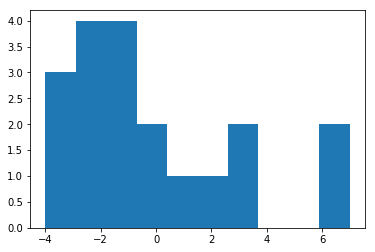

In [71]:
plt.hist(cr_data)